## Assignment 1 - Exploring CNNs on CIFAR-10 dataset
### Team members:
#### - Kaleb Roncatti de Souza
#### - Nelson Gomes Brasil Junior

In [1]:
!pip3 install visualkeras

In [2]:
import tensorflow as tf
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
import visualkeras
import os
import random as rn
from keras import callbacks


rs = 54
# Setting up random state to specific seed so we can have reproductibility
os.environ['PYTHONHASHSEED']=str(rs)
np.random.seed(rs)
tf.random.set_seed(rs)
rn.seed(rs)

In [3]:
# Loading train and test set
(x_train , y_train), (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
# Function to shuffle
def shuffle_tensor(x: np.ndarray , y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices, seed=rs)
    return tf.gather(x, shuffled_indices), tf.gather(y, shuffled_indices)

# Function to split dataset
def split_dataset(x: np.ndarray, y: np.ndarray, percentage: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if len(x) != len(y):
        raise ValueError("array x and y must have the same length")
    
    # Shuffling dataset
    x, y = shuffle_tensor(x=x, y=y)

    # Finding the splits after shuffling
    total_elements = len(y)
    data = int(percentage * total_elements)
    return x[0:data], y[0:data], x[data:], y[data:]


In [5]:
#################################################################
## Atividade 1. Splitting training and validation
x_train, y_train, x_val, y_val = split_dataset(x=x_train, y=y_train, percentage = 0.8)
print(f"We splitted the training dataset using the following percentage: {len(x_train)/(len(x_train) + len(x_val))}")
print(f"Training dataset has the following shape: x ==> {x_train.shape}, y ==> {y_train.shape}")
print(f"Validation dataset has the following shape: x ==> {x_val.shape}, y ==> {y_val.shape}")

We splitted the training dataset using the following percentage: 0.8
Training dataset has the following shape: x ==> (40000, 32, 32, 3), y ==> (40000, 1)
Validation dataset has the following shape: x ==> (10000, 32, 32, 3), y ==> (10000, 1)


In [6]:
# Normalize data between [0, 1]
x_train = tf.cast(x_train, tf.float32) / 255.0
x_val = tf.cast(x_val, tf.float32) / 255.0
x_test = tf.cast(x_test, tf.float32) / 255.0


# One hot encoding on labels
num_classes = len(np.unique(y_train))
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, y_train_oh.shape)

(40000, 32, 32, 3) (40000, 10)


In [7]:
# Checking if we have a balanced dataset
# Para o conjunto de treino
unique, counts = np.unique(y_train, return_counts=True)
print("Train ---> ", dict(zip(unique, counts)))
unique, counts = np.unique(y_val, return_counts=True)
print("Validation ---> ", dict(zip(unique, counts)))

Train --->  {0: 3968, 1: 4035, 2: 3988, 3: 3958, 4: 4005, 5: 4021, 6: 4038, 7: 3995, 8: 4015, 9: 3977}
Validation --->  {0: 1032, 1: 965, 2: 1012, 3: 1042, 4: 995, 5: 979, 6: 962, 7: 1005, 8: 985, 9: 1023}


We can consider that the dataset is more or less balanced. We could also adjust the weights based on their proportion, but for simplicity, let's keep going considering the dataset is completely balanced.

In [8]:
print(x_train[0].shape)


(32, 32, 3)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 7200)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                72010     
                                                                 
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
_________________________________________________________________


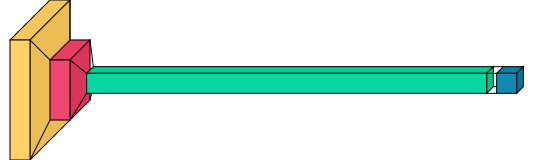

In [25]:
#################################################################
## Atividade 2. Creating a very simple convolutional neural net

def create_baseline_model(input_shape=x_train[0].shape, activation: str = "relu") -> tf.keras.Sequential():
    model = tf.keras.Sequential()

    # Convolutional layer with 32 filters, 3x3 each
    model.add(
        layers.Conv2D(
            filters=32, 
            kernel_size=(3, 3), 
            padding='valid', 
            activation='relu', 
            input_shape=x_train[0].shape))
    #Max pooling of size 3x3
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # Flattening
    model.add(layers.Flatten())
    # Output layer
    model.add(layers.Dense(10))

    return model

model = create_baseline_model()
model.summary()
# Taking a look at the neural net
visualkeras.layered_view(model)


In [26]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [27]:
# Training the baseline model and saving it
device = '/gpu:0' # or '/cpu:0' if you don't have GPU
with tf.device(device):
    model.fit(
        x_train, y_train_oh, 
        epochs=50, 
        batch_size=50,
        validation_data=(x_val, y_val_oh),
        verbose=1,
        callbacks=[
            callbacks.TerminateOnNaN(),
            callbacks.ModelCheckpoint(
                'weights_baseline.h5',
                save_best_only=True,
                verbose=1),
        ]
        )

Epoch 1/50
799/800 [============================>.] - ETA: 0s - loss: 2.0167 - accuracy: 0.2808
Epoch 1: val_loss improved from inf to 1.95416, saving model to weights_baseline.h5
800/800 [==============================] - 18s 22ms/step - loss: 2.0168 - accuracy: 0.2808 - val_loss: 1.9542 - val_accuracy: 0.3024
Epoch 2/50
800/800 [==============================] - ETA: 0s - loss: 1.9354 - accuracy: 0.3104
Epoch 2: val_loss improved from 1.95416 to 1.93570, saving model to weights_baseline.h5
800/800 [==============================] - 16s 20ms/step - loss: 1.9354 - accuracy: 0.3104 - val_loss: 1.9357 - val_accuracy: 0.2937
Epoch 3/50
798/800 [============================>.] - ETA: 0s - loss: 1.9072 - accuracy: 0.3173
Epoch 3: val_loss improved from 1.93570 to 1.88527, saving model to weights_baseline.h5
800/800 [==============================] - 13s 17ms/step - loss: 1.9072 - accuracy: 0.3174 - val_loss: 1.8853 - val_accuracy: 0.3135
Epoch 4/50
796/800 [============================>.] -

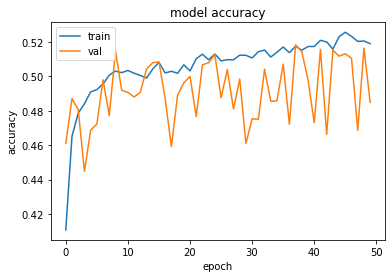

In [ ]:
# Observing the model
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()